# Circuit learning module: Lambeq's QuantumTrainer

This module performs the optimization with Lambeq's native optimizer. Because the circuits are constructed with Lambeq and DisCoPy, this optimizer is the natural choice. The code is based on the workflow presented in https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline.ipynb.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import glob
from pathlib import Path
import numpy as np
import pickle
import math

from discopy.utils import loads
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

from calibrate import calibrate

this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

# Uncomment if you do not want to access GPU
#os.environ["JAX_PLATFORMS"] = "cpu"

BATCH_SIZE = 64
EPOCHS = 4000
SEED = 0

## Select workload

In [2]:
# Select workload
#workload = "small"
workload = "medium"
#workload = "large"

# Select if we perform binary classification or multi-class classification
# Give number of qubits to create classes:
# 1 -> 2^1 = 2 classes i.e. binary classification
# 2 -> 2^2 = 4 classes
# ...
# 5 -> 2^5 = 32 classes, etc.

classification = 1

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//circuits//" + str(classification) + "//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

## Read circuits

We read the circuits from the pickled files.

In [3]:
def read_diagrams(circuit_paths):
    circuits = {}
    for serialized_diagram in circuit_paths:
        base_name = Path(serialized_diagram).stem
        f = open(serialized_diagram, "rb")
        diagram = pickle.load(f)
        circuits[base_name] = diagram
    return circuits


training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training, validation and test data

In [4]:
training_data, test_data, validation_data = None, None, None

data_path = this_folder + "//data//" + workload + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
    
def create_labeled_classes(data, classification):
    labeled_data = {}
    sorted_data = sorted(data, key=lambda d: d['time'])
    chunk_size = math.ceil(len(sorted_data)/2**classification)
    for i, clas in enumerate(chunks(sorted_data, chunk_size)):
        label = [0]*(2**classification)
        label[i] = 1
        for elem in clas:
            labeled_data[elem["name"]] = label
    return labeled_data


training_data_labels = create_labeled_classes(training_data, classification)
test_data_labels = create_labeled_classes(test_data, classification)
validation_data_labels = create_labeled_classes(validation_data, classification)

## Prepare circuits for the Lambeq optimizer

In [5]:
#all_circuits = list(training_circuits.values()) + list(test_circuits.values())

training_circuits_l = []
test_circuits_l = []
validation_circuits_l = []

training_data_labels_l = []
test_data_labels_l = []
validation_data_labels_l = []

# Organize circuits and labels in correct order into two lists which will be input for training the model
for key in training_data_labels:
    training_circuits_l.append(training_circuits[key])
    training_data_labels_l.append(training_data_labels[key])

for key in test_data_labels:
    test_circuits_l.append(test_circuits[key])
    test_data_labels_l.append(test_data_labels[key])
    
for key in validation_data_labels:
    validation_circuits_l.append(validation_circuits[key])
    validation_data_labels_l.append(validation_data_labels[key])

all_circuits = training_circuits_l + test_circuits_l + validation_circuits_l

train_syms = set([sym for circuit in training_circuits.values() for sym in circuit.free_symbols])
test_syms = set([sym for circuit in test_circuits.values() for sym in circuit.free_symbols])
val_syms = set([sym for circuit in validation_circuits.values() for sym in circuit.free_symbols])

print("Test circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()): ", test_syms.difference(train_syms))
print("Validation circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()): ", val_syms.difference(train_syms))

print("Total number of circuits: ", len(all_circuits))
print("Total number of variables: ", len(train_syms))

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 3200
}

Test circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()):  set()
Validation circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()):  set()
Total number of circuits:  121
Total number of variables:  76


## Select the model

Select the used model between `TketModel` or `NumpyModel`. `NumpyModel` can use JAX which speeds up the training.

In [6]:
#model = TketModel.from_diagrams(training_circuits_l, backend_config=backend_config)
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
model.initialise_weights()

## Define loss function and evaluation metrics

In [7]:
def acc(y_hat, y):
    return (np.sum(np.round(y_hat) == y) / len(y)) / 2

def loss(y_hat, y):
    return -np.sum(y * np.log(y_hat)) / len(y)

eval_metrics = {"acc": acc}

In [8]:
a, c = calibrate(loss, np.array(model.weights), A = 0.01*EPOCHS)

 -- Learning rate: a / ((A + n) ^ alpha) with a = 9.351814458031768, A = 40.0, alpha = 0.602
 -- Perturbation: c / (n ^ gamma) with c = 0.2, gamma = 0.101


## Initialize the trainer and the datasets

In [9]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 1.0, 'c': c, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

In [10]:
train_dataset = Dataset(training_circuits_l, training_data_labels_l)
val_dataset = Dataset(validation_circuits_l, validation_data_labels_l, shuffle=False)
test_dataset = Dataset(test_circuits_l, test_data_labels_l, shuffle=False)

## Train the model

In [11]:
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=100)

Epoch 1:     train/loss: 0.7871   valid/loss: 0.9425   train/acc: 0.5000   valid/acc: 0.6190
Epoch 100:   train/loss: 0.7302   valid/loss: 0.6990   train/acc: 0.5500   valid/acc: 0.4762
Epoch 200:   train/loss: 0.7080   valid/loss: 0.6302   train/acc: 0.5750   valid/acc: 0.7619
Epoch 300:   train/loss: 0.6813   valid/loss: 0.5654   train/acc: 0.5625   valid/acc: 0.8571
Epoch 400:   train/loss: 0.7007   valid/loss: 0.5911   train/acc: 0.6125   valid/acc: 0.7619
Epoch 500:   train/loss: 0.6813   valid/loss: 0.7465   train/acc: 0.6000   valid/acc: 0.5238
Epoch 600:   train/loss: 0.7114   valid/loss: 0.6303   train/acc: 0.5500   valid/acc: 0.6190
Epoch 700:   train/loss: 0.7220   valid/loss: 0.5793   train/acc: 0.5250   valid/acc: 0.7143
Epoch 800:   train/loss: 0.6419   valid/loss: 0.5212   train/acc: 0.7375   valid/acc: 0.8095
Epoch 900:   train/loss: 0.7290   valid/loss: 0.5185   train/acc: 0.7125   valid/acc: 0.7619
Epoch 1000:  train/loss: 0.6206   valid/loss: 0.4244   train/acc: 0.72

## Visualize the training process and results

[0.9224609  0.07753915]
[0.9753204  0.02467949]
[0.9505173  0.04948277]
[0.8913941 0.1086059]
[0.9807698 0.0192302]
[0.6761463  0.32385376]
[0.73102146 0.2689785 ]
[0.3242052 0.6757948]
[0.34320885 0.6567912 ]
[0.48536712 0.5146329 ]
[0.19644469 0.8035553 ]
[0.30828837 0.6917116 ]
[0.30202562 0.6979744 ]
[0.29753852 0.70246154]
[0.06388855 0.9361114 ]
[0.16677861 0.83322144]
[0.16977032 0.8302297 ]
[0.06517897 0.934821  ]
[0.12075764 0.87924236]
[0.0266101 0.9733899]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[1, 0]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
Test accuracy: 0.85


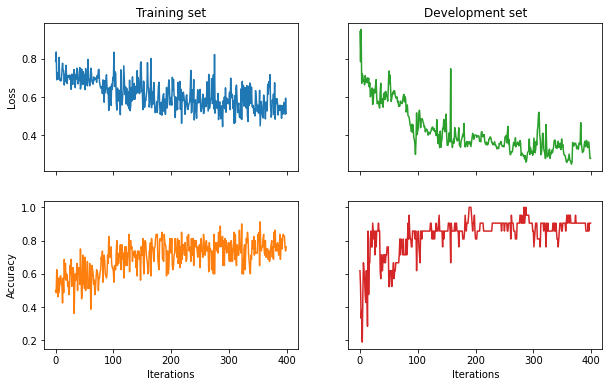

In [12]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

for e in model(test_circuits_l):
    print(e)
for e in test_data_labels_l:
    print(e)

# print test accuracy
test_acc = acc(model(test_circuits_l), test_data_labels_l)
print('Test accuracy:', test_acc.item())